In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # Changed to StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Bidirectional, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
data = pd.read_csv("D:\\4TH YEAR\\FYP\\taasha\\randsam_BABY.csv")

In [4]:
data['voltage_current_ratio'] = data['volData'] / (data['currentData'] + 1e-6)  # Add engineered features
data['power'] = data['volData'] * data['currentData']

In [5]:
input_features = ["Timestamp" , "volData" , "currentData"]
output_features = ['batTempData','socData','sohData','motTempData','speedData']

In [6]:
x = data[input_features].values
y = data[output_features].values

In [7]:
def remove_outliers(data):
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mask = np.all((data >= lower_bound) & (data <= upper_bound), axis=1)
    return data[mask], mask

x_cleaned, mask = remove_outliers(x)
y_cleaned = y[mask]

In [8]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

x_scaled = scaler_x.fit_transform(x_cleaned)
y_scaled = scaler_y.fit_transform(y_cleaned)

In [9]:
def create_sequences(x, y, sequence_length=20, stride=1):  # Increased sequence length
    x_seq, y_seq = [], []
    for i in range(0, len(x) - sequence_length, stride):
        x_seq.append(x[i:i + sequence_length])
        y_seq.append(y[i + sequence_length - 1])  # Predict last timestep
    return np.array(x_seq), np.array(y_seq)

sequence_length = 20
x_sequences, y_sequences = create_sequences(x_scaled, y_scaled, sequence_length)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(
    x_sequences, y_sequences, test_size=0.3, random_state=42)

In [11]:
model = Sequential([
    # Bidirectional GRU layers
    Bidirectional(GRU(512, return_sequences=True,
                     kernel_initializer='glorot_uniform',
                     recurrent_dropout=0.1),
                 input_shape=(sequence_length, x_train.shape[2])),
    LayerNormalization(),
    Dropout(0.3),

    Bidirectional(GRU(384, return_sequences=True,
                     kernel_initializer='glorot_uniform',
                     recurrent_dropout=0.1)),
    LayerNormalization(),
    Dropout(0.3),

    Bidirectional(GRU(256, return_sequences=False,
                     kernel_initializer='glorot_uniform',
                     recurrent_dropout=0.1)),
    LayerNormalization(),
    Dropout(0.3),

    Dense(512, activation='selu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='selu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='selu'),
    BatchNormalization(),

    Dense(len(output_features), activation='linear')
])


c:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate
)

In [13]:
model.compile(optimizer='adam', loss='huber', metrics=['mae', 'mse'])

In [14]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=15,
    min_lr=1e-6,
    verbose=1
)

In [15]:
history = model.fit(x_train, y_train, epochs=50, batch_size=128, validation_split=0.2, verbose=1)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 403ms/step - loss: 0.4516 - mae: 0.8138 - mse: 1.1708 - val_loss: 0.1183 - val_mae: 0.3994 - val_mse: 0.2374
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 378ms/step - loss: 0.0782 - mae: 0.3125 - mse: 0.1569 - val_loss: 0.0829 - val_mae: 0.3373 - val_mse: 0.1657
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 372ms/step - loss: 0.0423 - mae: 0.2296 - mse: 0.0846 - val_loss: 0.0530 - val_mae: 0.2647 - val_mse: 0.1059
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 370ms/step - loss: 0.0338 - mae: 0.2024 - mse: 0.0676 - val_loss: 0.0399 - val_mae: 0.2271 - val_mse: 0.0798
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - loss: 0.0310 - mae: 0.1923 - mse: 0.0621 - val_loss: 0.0388 - val_mae: 0.2208 - val_mse: 0.0776
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 359ms/step - loss: 0.0291 - mae: 0.1851 - mse: 0.0582 - val_loss: 0.0310 - val_mae: 0.1941 - val_mse: 0.0620
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 365ms/step - loss: 0.0276 - mae: 0.1796 - mse: 0.055

In [16]:
test_loss, test_mae, test_mse = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {np.sqrt(test_mse):.4f}")


Test Loss: 0.0210
Test MAE: 0.1407
Test MSE: 0.0419
Test RMSE: 0.2048


In [17]:
y_pred_scaled = model.predict(x_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step


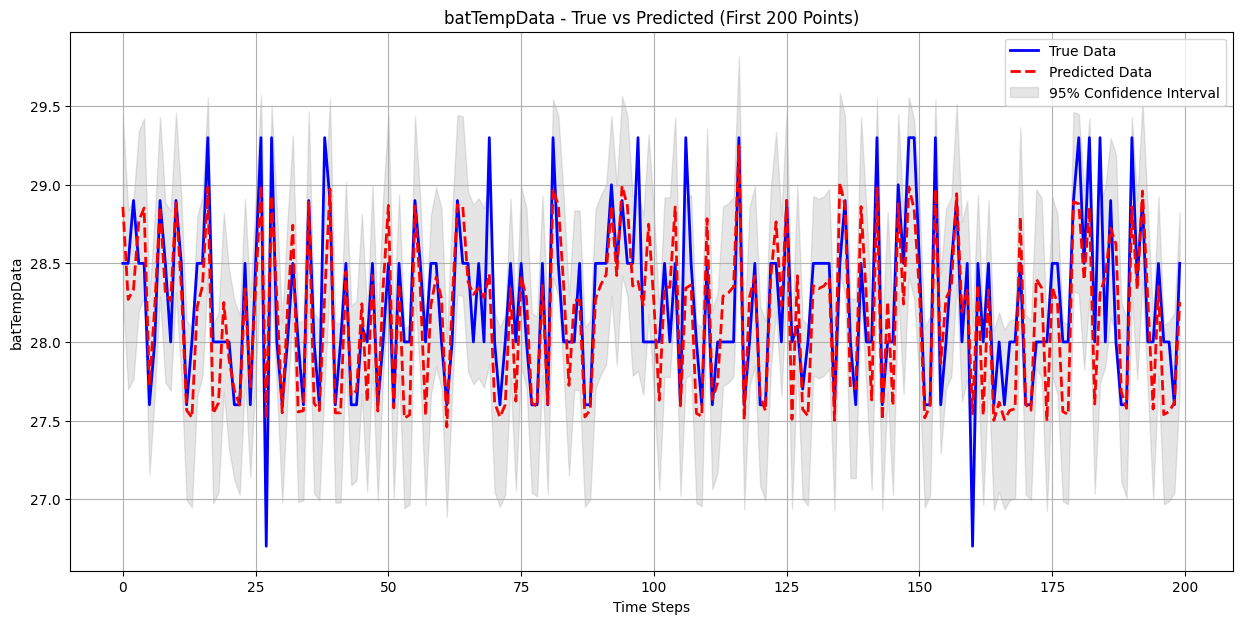


Metrics for batTempData:
MAE: 0.2336
RMSE: 0.2935
R² Score: 0.6418
Accuracy: 99.17%


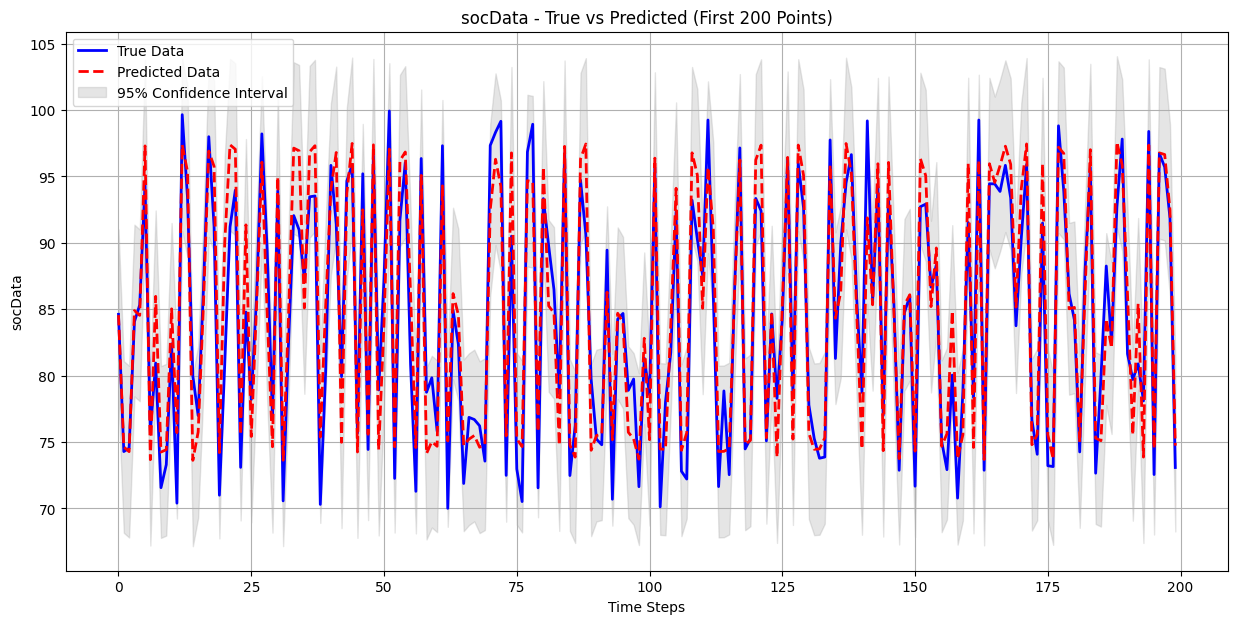


Metrics for socData:
MAE: 2.6913
RMSE: 3.2588
R² Score: 0.8726
Accuracy: 96.76%


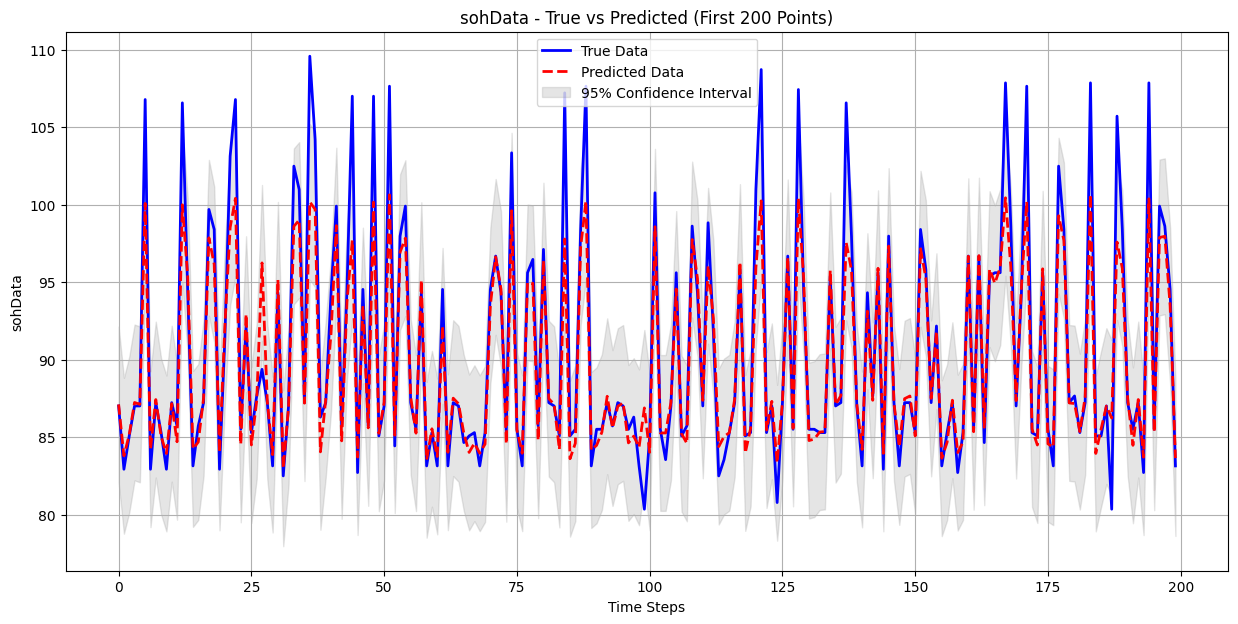


Metrics for sohData:
MAE: 1.4215
RMSE: 2.6575
R² Score: 0.8756
Accuracy: 98.55%


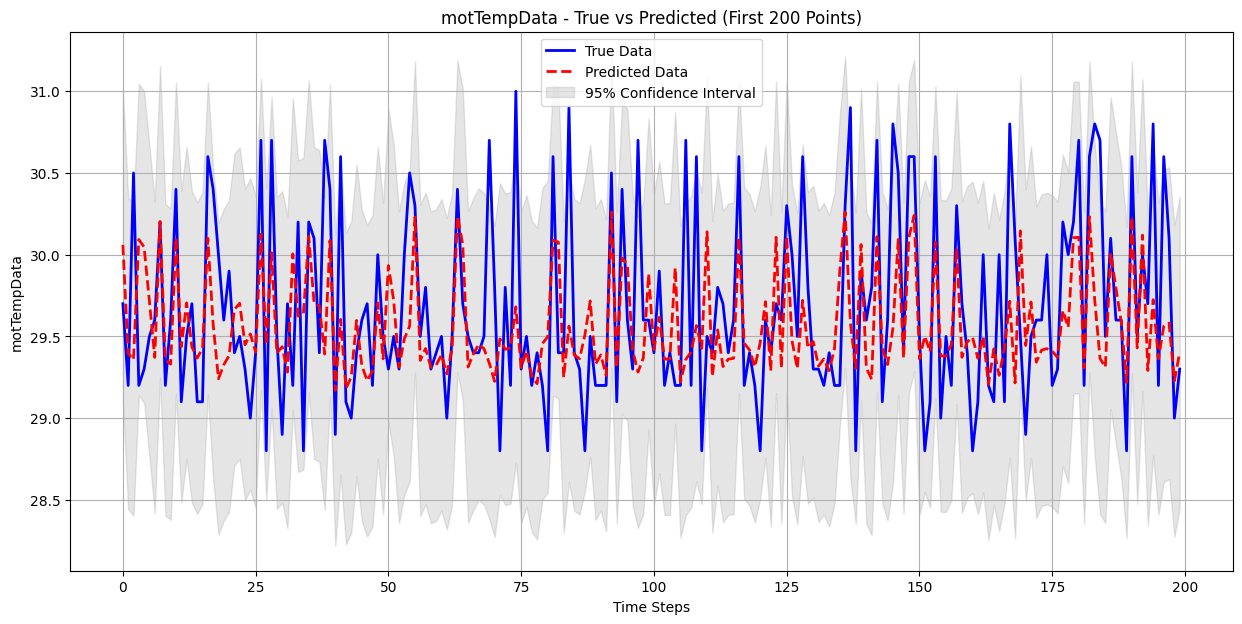


Metrics for motTempData:
MAE: 0.3666
RMSE: 0.4840
R² Score: 0.2294
Accuracy: 98.77%


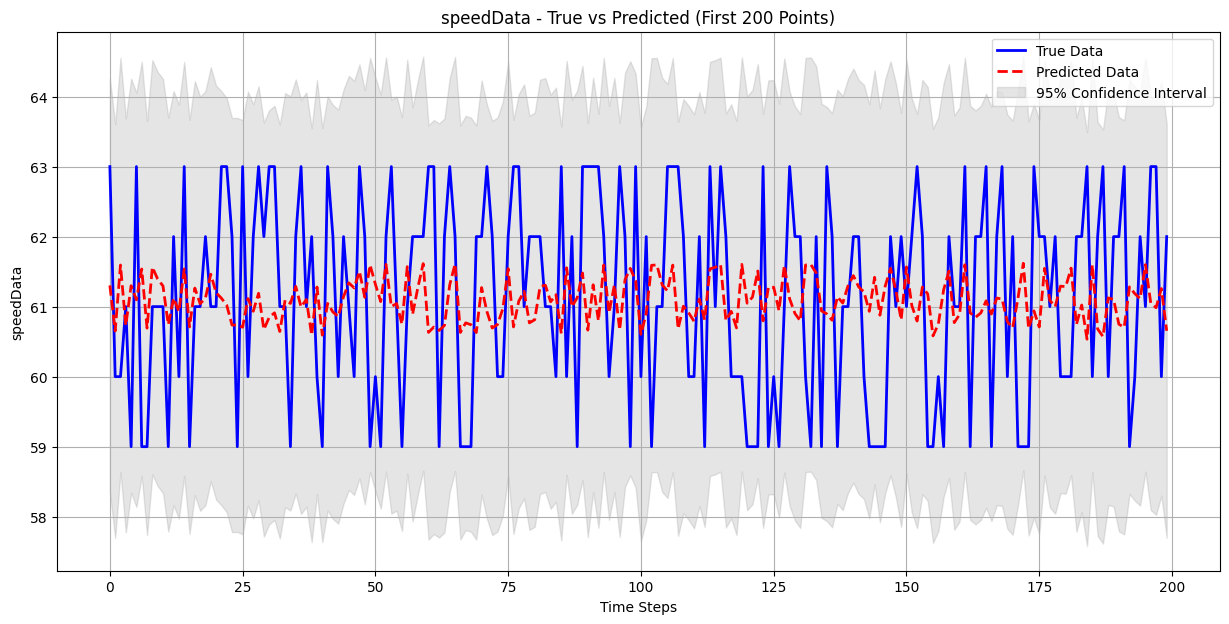


Metrics for speedData:
MAE: 1.2967
RMSE: 1.4786
R² Score: -0.0554
Accuracy: 97.88%

Overall Model Performance:
Overall MAE: 1.2019
Overall RMSE: 1.6345
Overall R² Score: 0.5128
Overall Accuracy: 98.23%


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score

# Initialize accumulators for overall metrics
total_mae = 0
total_rmse = 0
total_r2 = 0
total_mape = 0
num_features = len(output_features)

# Iterate over features
for i, feature in enumerate(output_features):
    plt.figure(figsize=(15, 7))

    # Calculate error bands
    residuals = y_true[:, i] - y_pred[:, i]
    std_residuals = np.std(residuals)

    # Plot actual vs predicted with confidence intervals
    plt.plot(y_true[:200, i], 'b-', label='True Data', linewidth=2)
    plt.plot(y_pred[:200, i], 'r--', label='Predicted Data', linewidth=2)
    plt.fill_between(range(200),
                     y_pred[:200, i] - 2 * std_residuals,
                     y_pred[:200, i] + 2 * std_residuals,
                     color='gray', alpha=0.2,
                     label='95% Confidence Interval')

    plt.title(f'{feature} - True vs Predicted (First 200 Points)')
    plt.xlabel('Time Steps')
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate and print metrics for each feature
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    rmse = np.sqrt(np.mean((y_true[:, i] - y_pred[:, i]) ** 2))
    r2 = r2_score(y_true[:, i], y_pred[:, i])
    mape = mean_absolute_percentage_error(y_true[:, i], y_pred[:, i]) * 100
    accuracy = 100 - mape

    print(f"\nMetrics for {feature}:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Accuracy: {accuracy:.2f}%")

    # Accumulate overall metrics
    total_mae += mae
    total_rmse += rmse
    total_r2 += r2
    total_mape += mape

# Calculate overall metrics
overall_mae = total_mae / num_features
overall_rmse = total_rmse / num_features
overall_r2 = total_r2 / num_features
overall_accuracy = 100 - (total_mape / num_features)

print("\nOverall Model Performance:")
print(f"Overall MAE: {overall_mae:.4f}")
print(f"Overall RMSE: {overall_rmse:.4f}")
print(f"Overall R² Score: {overall_r2:.4f}")
print(f"Overall Accuracy: {overall_accuracy:.2f}%")


In [19]:
model.save('GRU_nn.h5')
model.save_weights('GRU_model.weights.h5')

In [20]:
import numpy as np

def predict_sequence(input_sequence):
    """
    Make predictions using a sequence of inputs.

    Args:
        input_sequence (np.ndarray): Input sequence with shape (sequence_length, n_features)
    Returns:
        np.ndarray: Predicted values
    """
    # Ensure correct shape and scale input
    if input_sequence.shape[0] != sequence_length:
        raise ValueError(f"Input sequence must have length {sequence_length}")

    input_scaled = scaler_x.transform(input_sequence)
    input_scaled = input_scaled.reshape(1, sequence_length, -1)

    # Make prediction
    pred_scaled = model.predict(input_scaled, verbose=0)
    prediction = scaler_y.inverse_transform(pred_scaled)

    return prediction[0]

# Create a sample input sequence with the required length
# For demonstration, we will create a dummy sequence of 20 samples
# Each sample has 3 features. Replace this with actual data as needed.
sample_input = np.random.rand(sequence_length, 3)  # Random values for demonstration

# If you want to use specific values for the first entry and random for others:
sample_input[0] = [9262, 5.61756, 0.500818]  # Set your specific values for the first sample

# Make prediction with the sample input
predicted_values = predict_sequence(sample_input)

# Print results with labels
print("\nPredictions for input:")
for i, entry in enumerate(sample_input):
    print(f"Sample {i + 1}: {entry}")

print("\nPredicted Values:")
for feature, value in zip(output_features, predicted_values):
    print(f"{feature}: {value:.4f}")



Predictions for input:
Sample 1: [9.26200e+03 5.61756e+00 5.00818e-01]
Sample 2: [0.59865848 0.15601864 0.15599452]
Sample 3: [0.05808361 0.86617615 0.60111501]
Sample 4: [0.70807258 0.02058449 0.96990985]
Sample 5: [0.83244264 0.21233911 0.18182497]
Sample 6: [0.18340451 0.30424224 0.52475643]
Sample 7: [0.43194502 0.29122914 0.61185289]
Sample 8: [0.13949386 0.29214465 0.36636184]
Sample 9: [0.45606998 0.78517596 0.19967378]
Sample 10: [0.51423444 0.59241457 0.04645041]
Sample 11: [0.60754485 0.17052412 0.06505159]
Sample 12: [0.94888554 0.96563203 0.80839735]
Sample 13: [0.30461377 0.09767211 0.68423303]
Sample 14: [0.44015249 0.12203823 0.49517691]
Sample 15: [0.03438852 0.9093204  0.25877998]
Sample 16: [0.66252228 0.31171108 0.52006802]
Sample 17: [0.54671028 0.18485446 0.96958463]
Sample 18: [0.77513282 0.93949894 0.89482735]
Sample 19: [0.59789998 0.92187424 0.0884925 ]
Sample 20: [0.19598286 0.04522729 0.32533033]

Predicted Values:
batTempData: 28.1261
socData: 73.0360
sohDa